# Working With The CIFAR10 Dataset

This is it. You've seen how to define a simple convolutional neural network, compute loss w.r.t. the graph Variables, and make gradient updates manually and with `torch.nn.optim` package.
Now you might be thinking:

### What about the data?

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a `torch.*Tensor`.

- For images, packages such as `Pillow`, `OpenCV` are useful.
- For audio, packages such as `scipy` and `librosa`.
- For text, either raw Python or Cython based loading, or `NLTK` and `SpaCy` are useful.

Specifically for [Computer vision](), the creators of pytorch have generously created a package called `torchvision`, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`. This provides a huge convinence from writing boiler plate code.

We will use the **CIFAR10 dataset**. It has the classes: *‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’*. The images in CIFAR-10 are of size `3x32x32`, i.e. 3-channel color images of `32x32` pixels in size.

![CIFAR10 Dataset](../images/cifar10.png)

### Training an image classifier

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using `torchvision`.
2. Define a Convolution Neural Network.
3. Define a loss function.
4. Train the network on the training data.
5. Test the network on the test data.

#### 1. Loading and normalizing CIFAR10
Using `torchvision`, it’s extremely easy to load CIFAR10.

In [1]:
%matplotlib inline

# file manipulation
import os

# arrays and visualization
import numpy as np
import matplotlib.pyplot as plt

# pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

# Special package provided by pytorch
import torchvision
import torchvision.transforms as transforms

The output of the `torchvision` dataset are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

Define the data directory, i.e. where the data should be downloaded to. With the use of `os.path` module.

**NOTE:** `data_dir` could be modified to fit your use.

In [2]:
# Transform rule
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), 
                                                     (0.5, 0.5, 0.5))])

# download parameters
data_dir = '../datasets'
download = not os.path.exists(os.path.join(data_dir, 'cifar-10-batches-py'))

# Download the dataset
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, 
                                        download=download, transform=transform)
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, 
                                       download=download, transform=transform)

# loaders
trainset = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plane frog deer ship


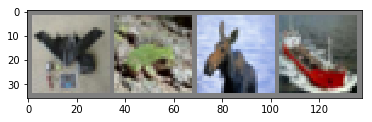

In [3]:
# Let's visualize the data

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))

# Get random training images
train_iter = iter(trainset)
images, labels = train_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(classes[ labels[i] ] for i in range(4)))

### 2. Define a Convolution Neural Network

It's time to define our neural network. You've already seen how to define a simple convolutional neural network in the last section. But this time, instead of a single color channel, we have 3-color channels, because the CIFAR10 dataset contains colored images.

In [4]:
class Network(nn.Module):
    
    def __init__(self, **kwargs):
        super(Network, self).__init__()
        
        # Hyper-parameters
        self._img_channels = kwargs.get('img_channels', 3)
        self._num_classes = kwargs.get('num_classes', 10)
        
        # 2 convolutional & 3 fully connected layers
        self.conv1 = nn.Conv2d(self._img_channels, 6, 1)
        self.conv2 = nn.Conv2d(6, 16, 1)
        flatten_size = self.conv2.out_channels * 8 * 8
        self.fc1 = nn.Linear(flatten_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, self._num_classes)
    
    def forward(self, x):
        # Convolutional layers
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # Flatten layer
        x = x.view(-1, self._flatten(x))
        # Fully connected layers
        x = F.relu(self.fc1(x))     # relu + linear
        x = F.dropout(x, p=0.5)     # 50% dropout
        x = F.relu(self.fc2(x))     # relu + linear
        x = F.sigmoid(self.fc3(x))  # sigmoid + linear
        return x
    
    def _flatten(self, x):
        size = x.size()[1:]  # input shape excluding batch dim.
        return torch.Tensor(size).numel()

In [5]:
# Instantiate the network and pass in our parameters
net = Network(img_channels=3, num_classes=len(classes))

### 3. Define a Loss function and optimizer

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [6]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)

### 4. Train the Network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize it.

In [7]:
for epoch in range(5):  # loop over the data multiple times

    # loop through the training dataset (batch by batch)
    for i, data in enumerate(trainset, 0):
        # get the inputs and labels
        inputs, labels = data
        # wrap them in Variable (explain in section 2.)
        inputs, labels = Variable(inputs), Variable(labels)
        
        # zero the optimizer gradient buffer
        # to prevent gradient accumulation.
        optimizer.zero_grad()
        
        # forward + backward + optimizer
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        print(f'\rEpoch: {epoch+1:,}\tIter: {i+1:,}\tLoss: {loss.data[0]:.4f}', end='')
    print('\n')  # line break


print('\nFinished training!')

Epoch: 1	Iter: 12,500	Loss: 2.1317

Epoch: 2	Iter: 12,500	Loss: 2.6726

Epoch: 3	Iter: 12,500	Loss: 2.2183

Epoch: 4	Iter: 12,500	Loss: 2.2183

Epoch: 5	Iter: 12,500	Loss: 2.4683


Finished training!
